# 勾配積分
学習モデルの説明可能性を高めるための手法として、Integrated Gradientsを説明する。

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

## このNotebookではInceptionV1という学習モデルを使用する

In [2]:
model = tf.keras.Sequential([
        hub.KerasLayer(name='inception_v1', 
            handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4', 
            trainable=False
        )
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    (None, 1001)              6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [3]:
def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
imagenet_labels = load_imagenet_labels(url)

img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

## 画像データの分類に対してIntegrated Gradientsを適用して、分類根拠を可視化する

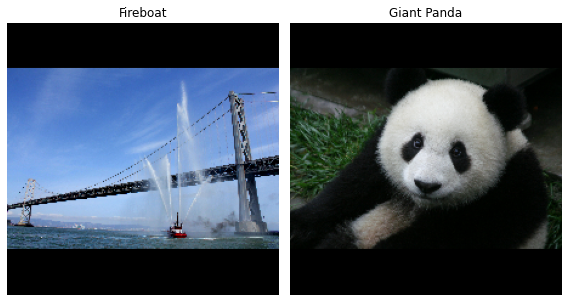

In [4]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 2, n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

In [5]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

## 学習済みInceptionV1モデルの分類結果を確認する

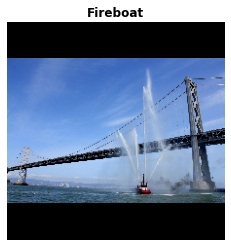

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


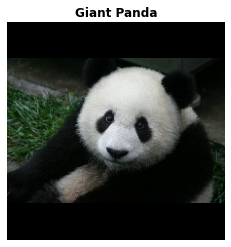

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [6]:
for (name, img_tensor) in img_name_tensors.items():
    plt.imshow(img_tensor)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()

    pred_label, pred_prob = top_k_predictions(img_tensor)
    for label, prob in zip(pred_label, pred_prob):
        print(f'{label}: {prob:0.1%}')

## Integrated Gradiants を計算する
ここで使用しているモデルInceptionV1は、

- 入力の特徴量空間、画像ピクセル値と
- ImageNetクラスを確率値によって定義する出力空間

との写像を記述する学習済み関数である。  
ニューラルネットワークの初期の解釈可能性メソッドは、勾配を使用して  
特徴量の重要度スコアを割り当てていました。しかし、勾配はモデル予測関数の  
局所的な変化のみを説明して、予測関数全体を完全には説明しない。  

モデルが個々のピクセルの範囲と正しいImageNetのクラスの関係を完全に学習すると、  
そのピクセルに対する勾配は飽和し、その意味合いは小さくなっていき、ゼロになる。  

上記のことを以下のシンプルなモデル関数で考える。

In [7]:
def f(x):
    """A simplified model function."""
    return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
    """A straight line path."""
    return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

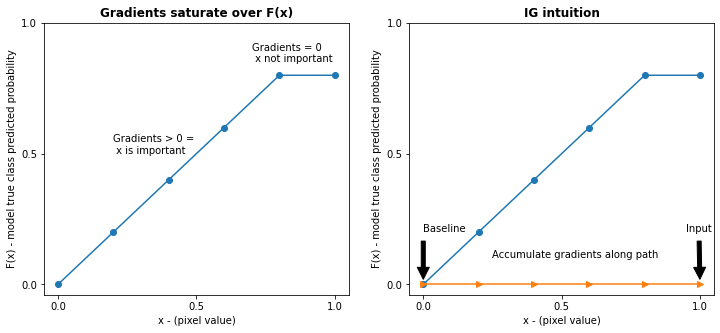

In [8]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

上の事象を説明する。  
左のグラフは下記の関数を表したものである。  
$$
    y = 
        \begin{cases}
            x & (x < 0.8) \\
            0.8 & (x \geq 0.8) \\
        \end{cases}
$$
この関数の勾配は、$0 \leq x < 0.8$の場合に正の値をとるが、$0.8 \leq x \leq 1.0$の場合にその勾配は0となる。  
勾配が正の状態にあるとき$x$ はクラスを予測する上で重要となるが、勾配が0になっている場合は$x$ が重要で  
なくなってしまう。  
この関数では、真のクラスに予測確率80%になるまでは$x$ は重要であるが、それよりも予測確率が高くなると$x$の  
重要度は小さくなる、もしくは$x$が連続な値でないことを意味する。

右のグラフはIntegrated Gradientsの直感を表したものである。  
IGの直感とは以下の2点によるものである。
- $x$の局所的な勾配の累積によるもの
- 予測確率に対してどの程度プラスマイナスに貢献しているかを重要度のスコアとして表すことによるもの

さらに、この直感をIGの計算の3ステップによってブレークダウンする。
1. 特徴空間の$[0, 1]$直線に沿って小さなステップによって補間画像を生成する
2. モデルの予測に対してモデルの各ステップで勾配を計算する
3. BaselineからInputの区間で、これらの累積局所勾配の近似積分を求める

この直感をより強化するために、上の3ステップを消防艇の画像に対して適用する。

## Baseline画像を生成する
Baseline画像はすべてのピクセル値が0となっている画像である。

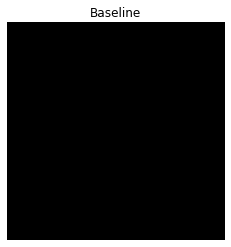

In [9]:
baseline = tf.zeros(shape=(224,224,3))

plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

## IntegratedGradiatsの数式を説明し、コード化する
$$
IntegratedGradients_i(x) := (x_i - x^{'}_{i}) \times \int_{\alpha=0}^{1} \frac{\partial F(x^{'}+\alpha \times (x - x^{'}))}{\partial x_i} d\alpha
$$

$$
\begin{array}{l}
i : 特徴量 \\
x : 入力画像 \\
x^{'} : Baseline画像 \\
\alpha : 特徴量を摂動させる補間定数 \\
\end{array}
$$

この積分は計算コストが高く数値的に解くのも困難である。そのため、下記の近似積分を数値的に解く。
$$
IntegratedGradients^{approx}_{i}(x) := (x_i - x^{'}_{i}) \times \frac{1}{m} \sum^{m}_{k=1} \frac{\partial F(x^{'}+\frac{k}{m} \times (x - x^{'}))}{\partial x_i}
$$

$$
\begin{array}{l}
i : 特徴量 \\
x : 入力画像 \\
x^{'} : Baseline画像 \\
k : スケーリングされた特徴量の摂動定数 \\
m : 近似リーマン積分のステップ数 \\
\end{array}
$$

### 上の数式をもとに線形補間を生成する
$\frac{k}{m}$を$0.02$として、$[0, 1]$を51個に均等に分割する。  
$0.02$を1ステップとして、51個の線形補間画像を生成する。

In [10]:
alphas = tf.linspace(start=0.0, stop=1.0, num=51)
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

### 線形補間画像を表示する
51個作成した線形補間画像から5個を取り出して表示

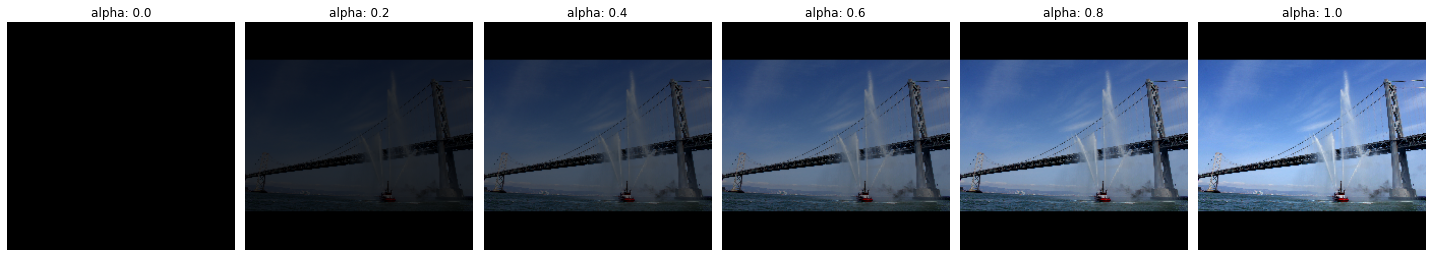

In [11]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout();

## 勾配を計算する
線形補間画像と予測クラスの確率との関係を計測するために勾配を計算する。  
画像の場合、勾配はどのピクセル値が予測クラスの確率に強い影響を与えるかを示している。

$$
IntegratedGradients^{approx}_{i}(x) := (x_i - x^{'}_{i}) \times \frac{1}{m} \sum^{m}_{k=1} \frac{\partial F(interpolated\ images)}{\partial x_i}
$$

In [12]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=tf.constant(555))

print(path_gradients.shape)

(51, 224, 224, 3)


ここで返却される値は各線形補間画像に対する各ピクセルの勾配である。  
この勾配は、微小量の画像の変化に対する対象クラスにおける予測確率の変化を測定するものと解釈できる。

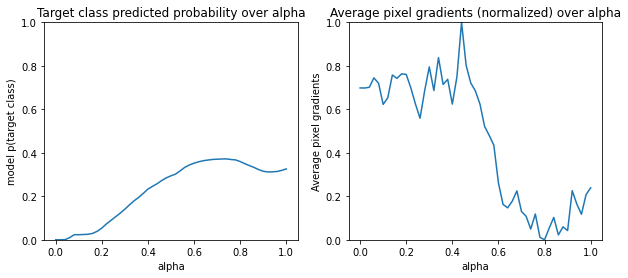

In [13]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

左のグラフは$\alpha$の変化を横軸にとり、縦軸にモデルが対象クラスと予測した確信度を取っている。  
このグラフからモデルの確信度は最終的に40%となり、$0.6 \leq \alpha \leq 1.0$で飽和状態になっていることがわかる。  
右のグラフは、全ピクセルの勾配の平均値の変化を表したものである。  
$0.0 \leq \alpha \leq 0.5$で勾配が大きく、モデルがよく学習できていることが想定される。  
しかし、$0.6 \leq \alpha \leq 1.0$の範囲で勾配が小さくなっている。この原因は以降で説明する。

## 累積勾配を積分近似によって求める
$$
IntegratedGradients^{approx}_{i}(x) := (x_i - x^{'}_{i}) \times \frac{1}{m} \sum^{m}_{k=1} gradients(interpolated\ images)
$$

In [14]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

ig = integral_approximation(gradients=path_gradients)
print(ig.shape)

(224, 224, 3)


## IGの計算を一つの関数にまとめる

In [15]:
@tf.function
def integrated_gradients(baseline, image, target_class_idx, m_steps=300, batch_size=16):
    # 1. Generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)

    # Accumulate gradients across batches
    integrated_gradients = 0.0

    # Batch alpha images
    ds = tf.data.Dataset.from_tensor_slices(alphas).batch(batch_size)

    for batch in ds:
        # 2. Generate interpolated images
        batch_interpolated_inputs = interpolate_images(baseline=baseline, image=image, alphas=batch)

        # 3. Compute gradients between model outputs and interpolated inputs
        batch_gradients = compute_gradients(images=batch_interpolated_inputs, target_class_idx=target_class_idx)

        # 4. Average integral approximation. Summing integrated gradients across batches.
        integrated_gradients += integral_approximation(gradients=batch_gradients)

    # 5. Scale integrated gradients with respect to input
    scaled_integrated_gradients = (image - baseline) * integrated_gradients
    return scaled_integrated_gradients


In [16]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555)
print(ig_attributions.shape)

(224, 224, 3)


In [17]:
def plot_img_attributions(baseline, image, target_class_idx, m_steps=tf.constant(50), cmap=None, overlay_alpha=0.4):

    attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

## IGにより画像の分類根拠を可視化
Attribution Mask画像の明るくなっている箇所が、入力画像を対象クラスに分類する際に注目したピクセルである。  
Overlay画像は入力画像にAttribution Maskを重ねた結果。

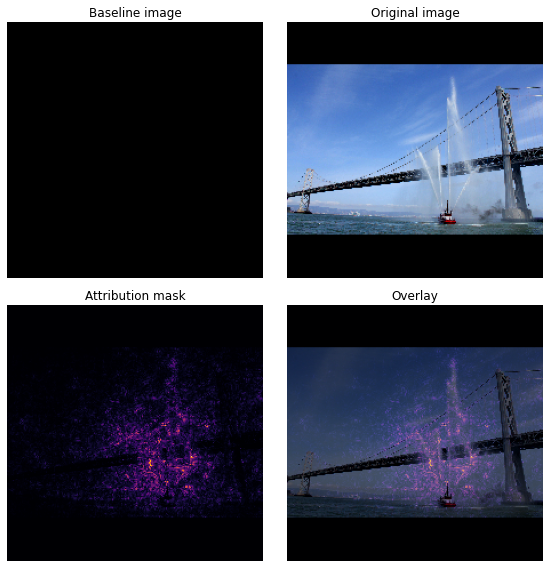

In [18]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=2400,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

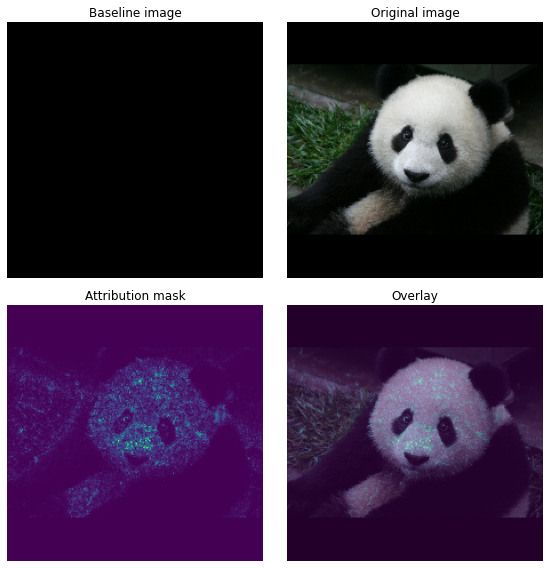

In [19]:
_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=389,
                          m_steps=1100,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)